# MSCA 32009 Health Analytics Final Project NLP
* Group 8: Beca Wang, Elly Yang, Jianghong Man
* Date: Mar 18, 2021

## II. Topics - use NLP to find the top 3 trending topics related to Covid-19

In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

# load package
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [3]:
# load data
tweets = pd.read_csv('data.csv', index_col=0)['text']
tweets.drop_duplicates(inplace = True)
tweets = tweets.str.lower()
tweets_before = tweets.copy()
tweets_before.head()

0    for another night of leftist funded social unrest because globalism/narcissism/socialism/liberalism needs another way to undermine the conservative movement to save constitution rights since the covid scam didn’t work out for the democrats. https://t.co/i7ov2tlgwq               
1    @senatorsinema not sure if you heard but corona virus was officially defeated by the hundreds of thousands of rioters. setting fire to targets was the vaccine.                                                                                                                        
2    @azzytheprotogen not only was he soldier in tf2, he was also in starfox 64\n\nthe man is a gaming legend, and his death was a tragedy, even more so when you realize the cause has been attributed to covid-19                                                                         
3    @kennedythacode rightfully? you call that rightful ? they didn’t even give him up to 5 hours before they started, but buhari dudbt talk o us

In [4]:
# popular hashtags
def find_hashtags(tweet): return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
hashtags = tweets.apply(find_hashtags)
pd.Series([k for j in hashtags[hashtags.apply(lambda i: i != [])] for k in j]).value_counts().head()

#covid19             2232
#coronavirus         1122
#covid               353 
#protests2020        250 
#blacklivesmatter    173 
dtype: int64

In [5]:
# clean tweets
def remove_hashtags(tweet):
    tweet = re.sub('# [\w]*', '', tweet)
    tweet = re.sub('#[\w]*', '', tweet)
    return tweet
tweets = tweets.apply(remove_hashtags)

def remove_users(tweet):
    tweet = re.sub('@ [\w]*', '', tweet)
    tweet = re.sub('@[\w]*', '', tweet)
    return tweet
tweets = tweets.apply(remove_users)

def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'bit.ly/\S+', '', tweet)
    tweet = tweet.strip('[link]')
    return tweet
tweets = tweets.apply(remove_links)

def remove_words(tweet):
    tweet = re.sub('covid', '', tweet)
    tweet = re.sub('coronavirus', '', tweet)
    tweet = re.sub('corona', '', tweet)
    return tweet
tweets = tweets.apply(remove_words)

tweets = tweets.str.replace('[^a-zA-Z#]', ' ')  # remove nonalpha characters

tweets = tweets.apply(lambda x: ' '.join([i for i in x.split() if len(i)>3])) # remove words with length not greater than 3

def remove_stopwords(tweet): return [i for i in simple_preprocess(tweet) if i not in stopwords.words('english')]
tweets = tweets.apply(remove_stopwords)

tweets[tweets.apply(len) < 3] = np.nan

tweets_after = tweets.apply(lambda x: np.nan if x is np.nan else ' '.join(x))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


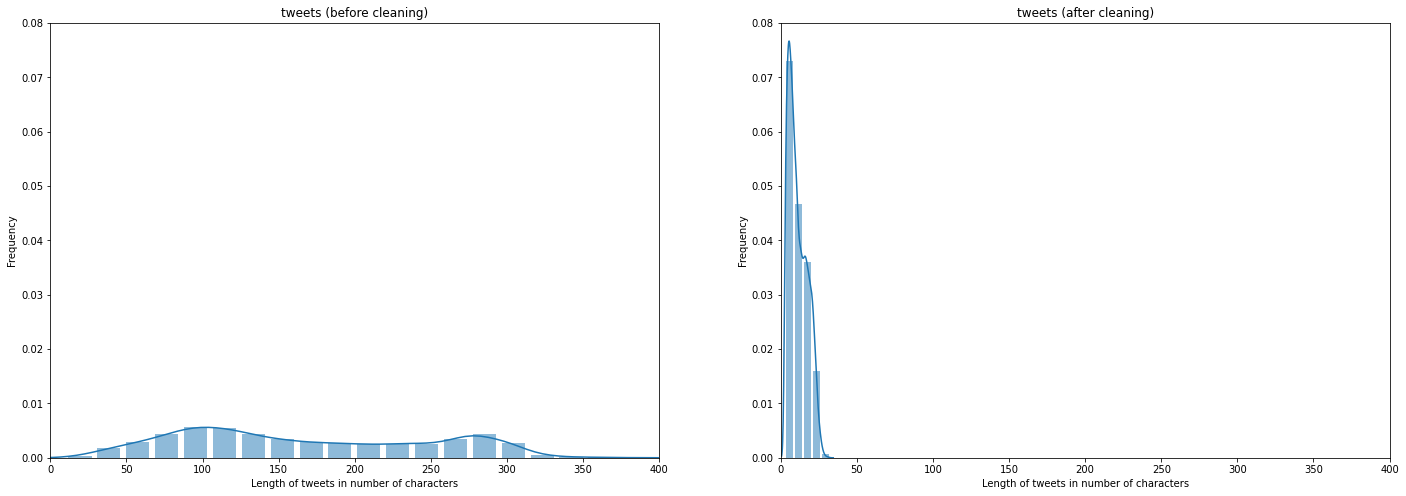

In [6]:
# visualize cleaning effects
plt.figure(figsize=(24, 8))

plt.subplot(1,2,1)
sns.distplot(tweets_before.str.len(), bins = 50, hist_kws={'alpha': 0.5,'rwidth':0.8})
plt.title('tweets (before cleaning)')
plt.xlabel('Length of tweets in number of characters')
plt.ylabel('Frequency')
plt.xlim([0,400])
plt.ylim([0,.08])

plt.subplot(1,2,2)
sns.distplot(tweets.str.len(), bins = 5, hist_kws={'alpha': 0.5,'rwidth':0.8})
plt.title('tweets (after cleaning)')
plt.xlabel('Length of tweets in number of characters')
plt.ylabel('Frequency')
plt.xlim([0,400])
plt.ylim([0,.08])

plt.show()

In [7]:
# text normalization
df = pd.DataFrame({'before cleaning': tweets_before, 'after cleaning': tweets_after, 'tokenization': tweets})
df.dropna(inplace = True)
tweets = df['tokenization']

bi = gensim.models.Phrases(tweets, min_count=10, threshold=100)
bigram_model = gensim.models.phrases.Phraser(bi)
def get_bigram(tweet): return [bigram_model[i] for i in tweet]
bigrams = get_bigram(tweets)

def lemmatization(tweet):
    output = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for i in tweet: output.append([token.lemma_ for token in nlp(' '.join(i)) if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']])
    return output
tweets_lem = lemmatization(bigrams)
#  [list(x) for x in set(tuple(x) for x in lemmatization(bigrams))]

def stemming(tweet):
    output = []
    for i in tweet: output.append([PorterStemmer().stem(j) for j in i])
    return output
tweets_stem = stemming(tweets_lem)

df['lemmatization'] = tweets_lem
df['stemming'] = tweets_stem
df.reset_index(inplace = True)

In [8]:
# latent dirichlet allocation (LDA)
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='[a-zA-Z0-9]{3,}', analyzer='word')
vec = vectorizer.fit_transform(df['stemming'].apply(lambda x: ' '.join(x)))

from sklearn.decomposition import LatentDirichletAllocation
model = LatentDirichletAllocation(n_components=3, random_state=0)
model.fit_transform(vec)
print('Log Likelihood: ', model.score(vec)) # higher the better
print('Perplexity: ', model.perplexity(vec)) # lower the better

# dominant topic for each tweet
df['Topic (dominant)'] = np.argmax(np.round(model.transform(vec), 2), axis=1)
df.tail()

Log Likelihood:  -1040301.6999366118
Perplexity:  791.5485146029729


,index,before cleaning,after cleaning,tokenization,lemmatization,stemming,Topic (dominant)
21966,23833,"chinese firms say coronavirus vaccine will be ready by end of year, '99 percent' effective\nhttps://t.co/lub5ujrjqr #news #bibleprophecy #truth #knowledge #wisdom #economist #endtimes #revelation",chinese firms vaccine ready year percent effective,"[chinese, firms, vaccine, ready, year, percent, effective]","[chinese, firm, vaccine, ready, year, percent, effective]","[chines, firm, vaccin, readi, year, percent, effect]",2
21967,23834,"coronavirus: b.c. parents weigh risks as classrooms reopen june 1 - [coronavirus], source: global news - https://t.co/gbdnvux3pp https://t.co/gm7blt4rl3",parents weigh risks classrooms reopen june source global news,"[parents, weigh, risks, classrooms, reopen, june, source, global, news]","[parent, weigh, risk, classroom, reopen, source]","[parent, weigh, risk, classroom, reopen, sourc]",0
21968,23835,"opinion | remember, no one is coming to save us https://t.co/dxv0vymgqj",opinion remember coming save,"[opinion, remember, coming, save]","[opinion, remember, come, save]","[opinion, rememb, come, save]",0
21969,23836,contact tracing limits covid-19 cases in northern indian state https://t.co/hecxyzt355 @voanews,contact tracing limits cases northern indian state,"[contact, tracing, limits, cases, northern, indian, state]","[contact_trace, limit, indian, state]","[contact_trac, limit, indian, state]",2
21970,23837,"apart from the tragic human consequences of #covid19, german government’s anti-crisis measures sum up to ""an astronomic value of eur 1.9tr"", according to @deutschebank https://t.co/1gcy825r9x\n\nlet’s make sure we are spending it wisely. \n\n#healthyrecovery https://t.co/mrtyeijh8u",apart tragic human consequences german government anti crisis measures astronomic value according make sure spending wisely,"[apart, tragic, human, consequences, german, government, anti, crisis, measures, astronomic, value, according, make, sure, spending, wisely]","[apart, tragic, human, consequence, german, government, anti, crisis, measure, astronomic, value, accord, make, sure, spending, wisely]","[apart, tragic, human, consequ, german, govern, anti, crisi, measur, astronom, valu, accord, make, sure, spend, wise]",1


In [9]:
# top 10 keywords for each topic
keywords = []
for topic_weights in model.components_: keywords.append(np.array(vectorizer.get_feature_names()).take((-topic_weights).argsort()[:10]))
pd.DataFrame(keywords, columns = ['Word '+str(i) for i in range(10)], index = ['Topic '+str(i) for i in range(3)]).T

,Topic 0,Topic 1,Topic 2
Word 0,peopl,protest,case
Word 1,say,peopl,death
Word 2,home,riot,peopl
Word 3,work,make,number
Word 4,stay,trump,report
Word 5,still,test,kill
Word 6,need,countri,time
Word 7,help,viru,year
Word 8,viru,busi,die
Word 9,safe,think,month


# III. Sentiment Analysis

In [10]:
# install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# install pyspark
! pip install --ignore-installed -q pyspark==2.4.4
! pip install --ignore-installed -q spark-nlp==2.7.1

# start spark session
import sparknlp
spark = sparknlp.start()
print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)
! cd ~/.ivy2/cache/com.johnsnowlabs.nlp/spark-nlp_2.11/jars && ls -lt

openjdk version "1.8.0_282"
OpenJDK Runtime Environment (build 1.8.0_282-8u282-b08-0ubuntu1~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.282-b08, mixed mode)
     |████████████████████████████████| 215.7MB 75kB/s 
     |████████████████████████████████| 204kB 19.0MB/s 
     |████████████████████████████████| 143kB 9.5MB/s 
Spark NLP version 2.7.1
Apache Spark version: 2.4.4
total 39960
-rw-r--r-- 1 root root 40918604 Jan  8 21:03 spark-nlp_2.11-2.7.1.jar


In [11]:
from sparknlp.pretrained import PretrainedPipeline

In [19]:
# topic0 = df[df['Topic (dominant)'] == 0]
# sentiment = PretrainedPipeline('analyze_sentiment', lang='en')
# topic0['sentiment'] = topic0['after cleaning'].apply(lambda x: sentiment.annotate(x)['sentiment'])
# topic0['sentiment'].value_counts().to_frame().plot(kind = 'barh')

In [ ]:
topic0 = df[df['Topic (dominant)'] == 0]
sentiment_imdb_glove = PretrainedPipeline('analyze_sentimentdl_glove_imdb', lang='en')
topic0['sentiment'] = topic0['after cleaning'].apply(lambda x: sentiment_imdb_glove.annotate(x)['sentiment'])

In [ ]:
topic1 = df[df['Topic (dominant)'] == 1]
sentiment_imdb_glove = PretrainedPipeline('analyze_sentimentdl_glove_imdb', lang='en')
topic1['sentiment'] = topic1['after cleaning'].apply(lambda x: sentiment_imdb_glove.annotate(x)['sentiment']) 

In [ ]:
topic2 = df[df['Topic (dominant)'] == 2]
sentiment_imdb_glove = PretrainedPipeline('analyze_sentimentdl_glove_imdb', lang='en')
topic2['sentiment'] = topic2['after cleaning'].apply(lambda x: sentiment_imdb_glove.annotate(x)['sentiment'])]

# **IV. Visualization**

##### **Bar Charts**

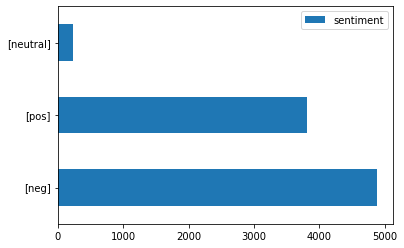

In [129]:
topic0['sentiment'].value_counts().to_frame().plot(kind = 'barh')

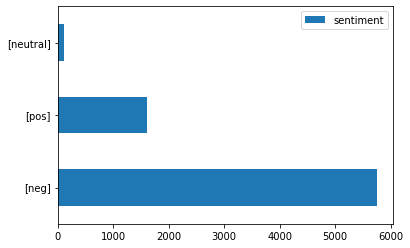

In [130]:
topic1['sentiment'].value_counts().to_frame().plot(kind = 'barh')

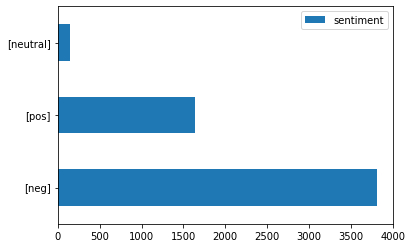

In [131]:
topic2['sentiment'].value_counts().to_frame().plot(kind = 'barh')

#### **Pie Charts**

##### **Topic0**

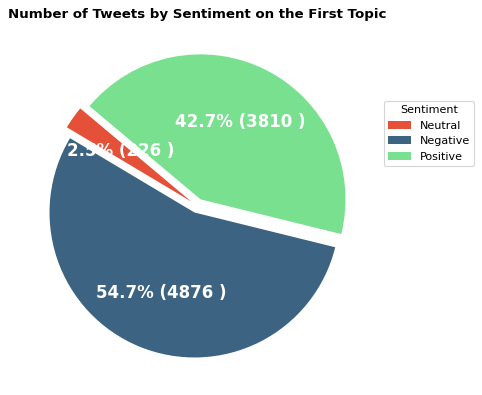

In [70]:
# Draw Plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [topic0.sentiment.value_counts()[-1], topic0.sentiment.value_counts()[0], topic0.sentiment.value_counts()[1]]
categories = ['Neutral', 'Negative', 'Positive']
explode = [0.05,0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['#e55039', '#3c6382', '#78e08f'],
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=15, weight=700)
ax.set_title("Number of Tweets by Sentiment on the First Topic", fontsize=12, fontweight="bold")
plt.show()

#####**Topic1**

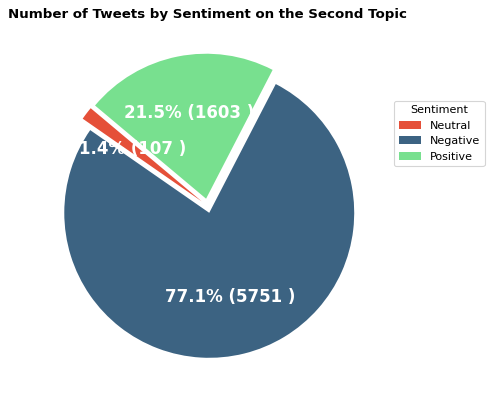

In [75]:
# Draw Plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [topic1.sentiment.value_counts()[-1], topic1.sentiment.value_counts()[0], topic1.sentiment.value_counts()[1]]
categories = ['Neutral', 'Negative', 'Positive']
explode = [0.05,0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['#e55039', '#3c6382', '#78e08f'],
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=15, weight=700)
ax.set_title("Number of Tweets by Sentiment on the Second Topic", fontsize=12, fontweight="bold")
plt.show()

#####**Topic2**

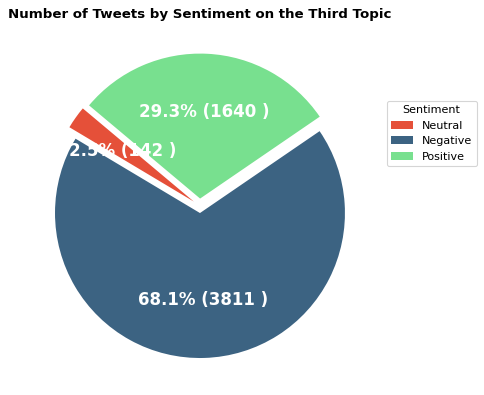

In [76]:
# Draw Plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [topic2.sentiment.value_counts()[-1], topic2.sentiment.value_counts()[0], topic2.sentiment.value_counts()[1]]
categories = ['Neutral', 'Negative', 'Positive']
explode = [0.05,0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['#e55039', '#3c6382', '#78e08f'],
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=15, weight=700)
ax.set_title("Number of Tweets by Sentiment on the Third Topic", fontsize=12, fontweight="bold")
plt.show()

In [ ]:
data.loc[data['sentiment'] == "'neg'"]

####**Output files for backup**

In [23]:
topic0.to_csv('topic0.csv', index = False)
topic1.to_csv('topic1.csv', index = False)
topic2.to_csv('topic2.csv', index = False)

files.download('topic0.csv')
files.download('topic1.csv')
files.download('topic2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [94]:
uploaded = files.upload()

Saving topic0.csv to topic0 (1).csv
Saving topic1.csv to topic1 (1).csv
Saving topic2.csv to topic2 (1).csv


In [122]:
df0 = pd.read_csv('topic0.csv')
df1 = pd.read_csv('topic1.csv')
df2 = pd.read_csv('topic2.csv')

df0['sentiment'] =  df0['sentiment'].apply(lambda x: x.replace('[','').replace(']','')) 
df1['sentiment'] =  df1['sentiment'].apply(lambda x: x.replace('[','').replace(']','')) 
df2['sentiment'] =  df2['sentiment'].apply(lambda x: x.replace('[','').replace(']','')) 

In [100]:
# def lemmatization(tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     tweets_out = []
#     for sent in tweets:
#         doc = nlp(" ".join(sent)) 
#         tweets_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return tweets_out

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# # python3 -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])

#### **Word Cloud**

##### **Topic0**

In [124]:
df0_pos = df0[df0['sentiment'] == "'pos'"]
df0_neg = df0[df0['sentiment'] == "'neg'"]

In [125]:
all_words0_pos = ' '.join([text for text in df0_pos['after cleaning']])
all_words0_neg = ' '.join([text for text in df0_neg['after cleaning']])

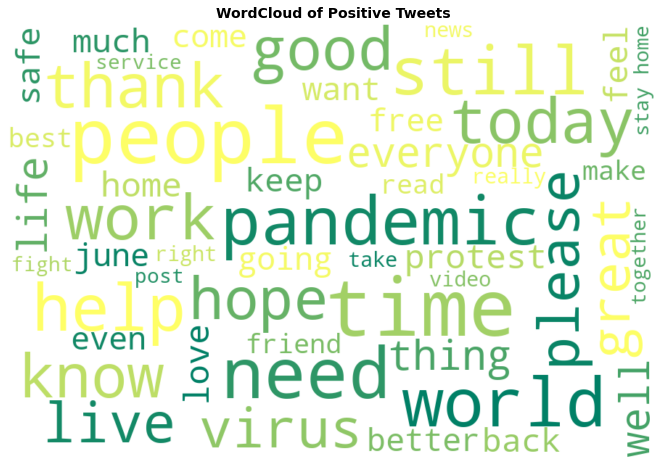

In [126]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='white', 
                      max_words=50,colormap='summer').generate(all_words0_pos)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Positive Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

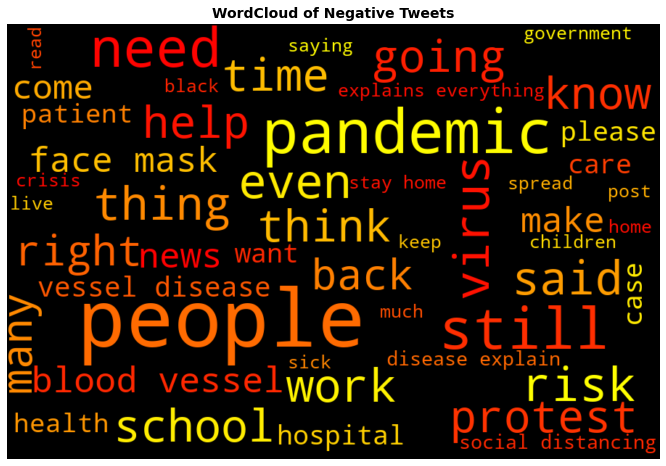

In [127]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='black', 
                      max_words=50,colormap='autumn').generate(all_words0_neg)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Negative Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

##### **Topic1**

In [115]:
df1_pos = df1[df1['sentiment'] == "'pos'"]
df1_neg = df1[df1['sentiment'] == "'neg'"]

all_words1_pos = ' '.join([text for text in df1_pos['after cleaning']])
all_words1_neg = ' '.join([text for text in df1_neg['after cleaning']])

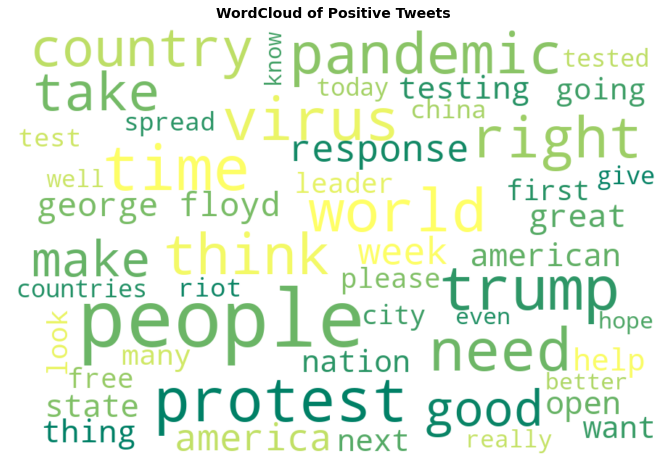

In [116]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='white', 
                      max_words=50,colormap='summer').generate(all_words1_pos)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Positive Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

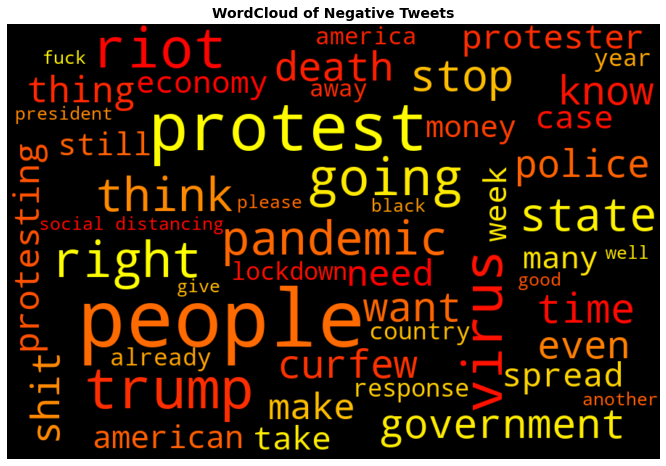

In [117]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='black', 
                      max_words=50,colormap='autumn').generate(all_words1_neg)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Negative Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

##### **Topic2**

In [118]:
df2_pos = df2[df2['sentiment'] == "'pos'"]
df2_neg = df2[df2['sentiment'] == "'neg'"]

all_words2_pos = ' '.join([text for text in df2_pos['after cleaning']])
all_words2_neg = ' '.join([text for text in df2_neg['after cleaning']])

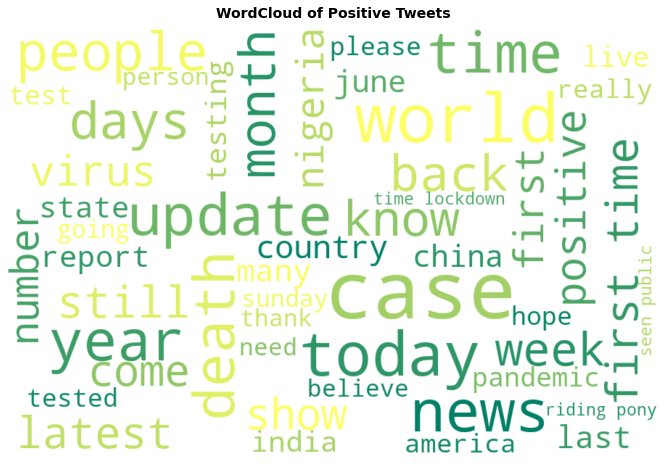

In [119]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='white', 
                      max_words=50,colormap='summer').generate(all_words2_pos)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Positive Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

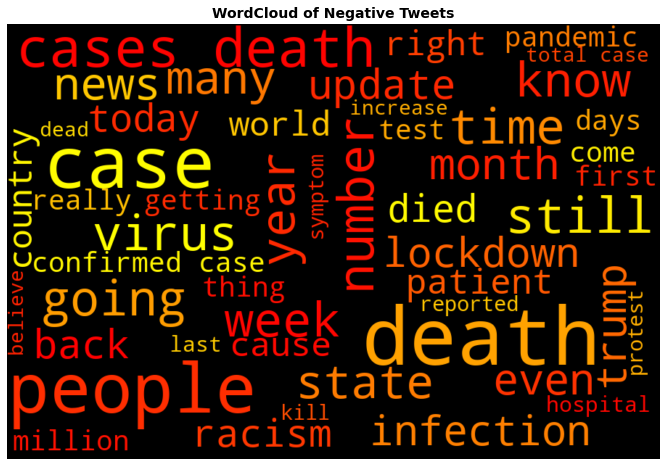

In [120]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='black', 
                      max_words=50,colormap='autumn').generate(all_words2_neg)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Negative Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
#df0[df0['sentiment'] == "'neg'"]

# Reference
* https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/1.SparkNLP_Basics.ipynb#scrollTo=U8AXeuY0_9hx
* https://ourcodingclub.github.io/tutorials/topic-modelling-python/
* https://towardsdatascience.com/religion-on-twitter-5f7b84062304
* https://github.com/HurmetNoka/religion_on_twitter